In [1]:
import os, warnings, gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.cm as cm

import PIL

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Data

In [2]:
train_path = "../input/digikalasupercup/dk-dataset/dataset/train"
test_path = "../input/digikalasupercup/dk-dataset/dataset/test"

W = 300
H = 300

In [3]:
# train_datagen = ImageDataGenerator(rescale=1/255, 
#                                    validation_split=0.2)
train_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                  validation_split=0.2,
                                  rotation_range=90,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
                                                train_path,
                                                target_size=(W, H),  
                                                batch_size=32,
                                                subset='training',
                                                seed=0,
                                                class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
                                                train_path, 
                                                target_size=(W, H),  
                                                batch_size=32,
                                                subset='validation',
                                                seed=0,
                                                class_mode='binary')

print("\n", train_generator.class_indices)

Found 6866 images belonging to 2 classes.
Found 1716 images belonging to 2 classes.

 {'negative': 0, 'positive': 1}


# Create Model

In [4]:
# dropout_rate = 0.02
# conv_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(W,H,3))
# x = tf.keras.layers.GlobalMaxPooling2D(name="gap")(conv_model.output)
# # x = tf.keras.layers.Flatten(name="flatten")(x)
# x = tf.keras.layers.Dense(256, activation='relu', name="fc1")(x)
# if dropout_rate > 0:
#     x = tf.keras.layers.Dropout(dropout_rate, name="dropout_out")(x)
# output = tf.keras.layers.Dense(1, activation='sigmoid', name="fc_out")(x)

# model = tf.keras.Model(conv_model.input, output)

# model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', "AUC"])

# model.summary()

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(W, H, 3), padding="same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, 3, activation='relu', name="last_conv"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', "AUC"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
last_conv (Conv2D)           (None, 35, 35, 64)        7

# Train Model

In [6]:
%%time
gc.collect()

cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, mode="max", restore_best_weights=True, verbose=1)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, mode="max", min_lr=0.00005, verbose=1)

history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[cb_lr, cb_es])

Epoch 1/20
215/215 [==============================] - 221s 990ms/step - loss: 0.7058 - accuracy: 0.4937 - auc: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.4994 - val_auc: 0.5070
Epoch 2/20
215/215 [==============================] - 196s 911ms/step - loss: 0.6928 - accuracy: 0.5079 - auc: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.5175 - val_auc: 0.5241
Epoch 3/20
215/215 [==============================] - 195s 906ms/step - loss: 0.6934 - accuracy: 0.4981 - auc: 0.4968 - val_loss: 0.6930 - val_accuracy: 0.5087 - val_auc: 0.5091
Epoch 4/20
215/215 [==============================] - 194s 903ms/step - loss: 0.6942 - accuracy: 0.4958 - auc: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc: 0.5023

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
215/215 [==============================] - 194s 904ms/step - loss: 0.6933 - accuracy: 0.4926 - auc: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5064 - val_auc: 0.5006
Epoch 6/20
215/215 [=========

# Load Test Images

In [7]:
test_images_data = []
test_images_name = []

for img in tqdm(os.listdir(test_path)):
    file_name = img
    img = os.path.join(test_path, img)
    img = PIL.Image.open(img)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img = np.array(img) / 255.
    img = tf.image.resize(img, (W,H))
    img = np.expand_dims(img, axis=0)
    test_images_data.append(img)
    test_images_name.append(file_name)
print("Number of test images: ", len(test_images_name))

  0%|          | 0/1103 [00:05<?, ?it/s]

Number of test images:  1103


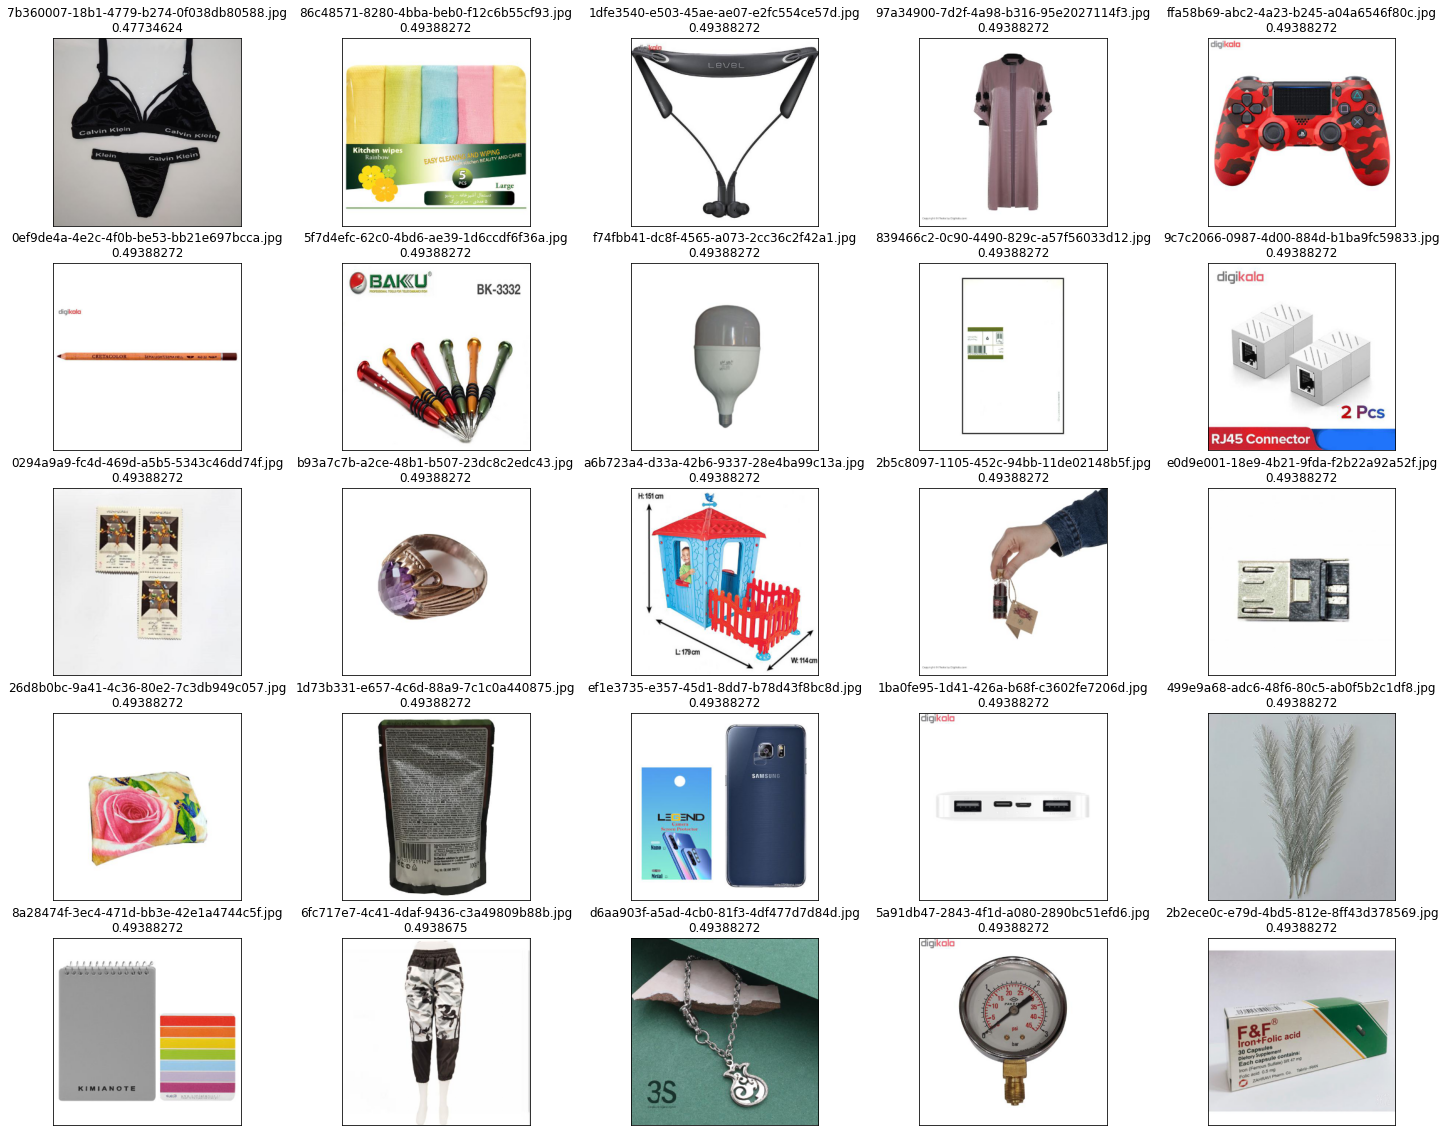

In [8]:
plt.figure(figsize=(25,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images_data[i+25][0])
    pred = model.predict(test_images_data[i+25])
    plt.title(test_images_name[i]+ "\n"+str(pred[0][0]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Debug Model (Grad-CAM)

In [9]:
last_conv_layer_name = "last_conv" #conv_model.layers[-1].name

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.1):

    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)
    
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img,0,255) / 255.
    
    return superimposed_img

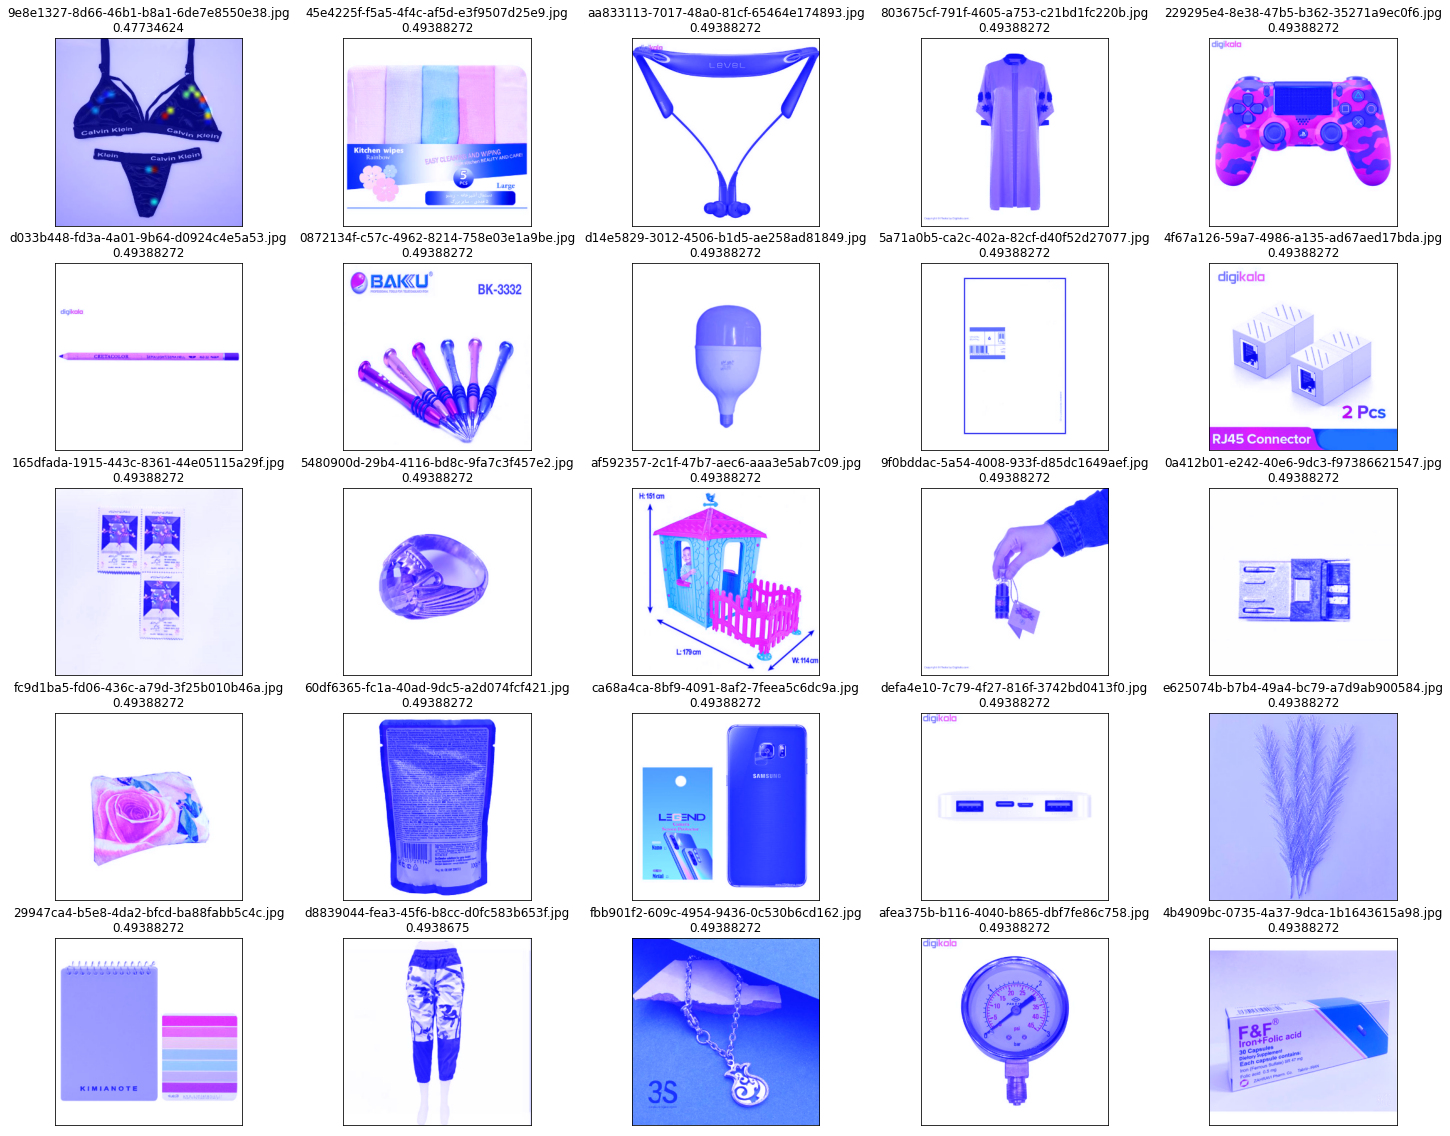

In [10]:
plt.figure(figsize=(25,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    img_array = test_images_data[i+25]
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    gc = display_gradcam(img_array[0], heatmap, alpha=0.9)
    
    plt.imshow(gc)
    plt.title(test_images_name[i+25]+ "\n"+str(preds[0][0]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Predict For Submission

In [11]:
preds = model.predict(np.array(test_images_data).squeeze()).squeeze()
submission = pd.DataFrame(data={"name": test_images_name, "predicted": np.round(preds).astype(np.int32)})
submission.to_csv("output.csv", index=False)
submission.head()

,name,predicted
0,7b360007-18b1-4779-b274-0f038db80588.jpg,0
1,86c48571-8280-4bba-beb0-f12c6b55cf93.jpg,0
2,1dfe3540-e503-45ae-ae07-e2fc554ce57d.jpg,0
3,97a34900-7d2f-4a98-b316-95e2027114f3.jpg,0
4,ffa58b69-abc2-4a23-b245-a04a6546f80c.jpg,0


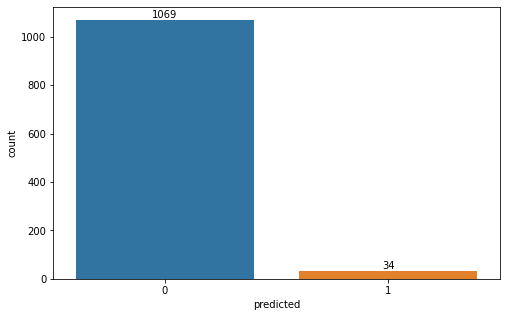

In [12]:
plt.figure(figsize=(8,5))
ax = sns.countplot(submission["predicted"])
ax.bar_label(ax.containers[0])
plt.show()